In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax

from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv("data/fer2013.csv")

class_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x=class_labels,
             y=[list(data['emotion']).count(i) for i in np.unique(data['emotion'])],
             color=np.unique(data['emotion']),
             color_continuous_scale="Emrld")

fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Number of Images")
fig.update_layout(showlegend=True,
                  title={
                      'text': 'Train Data Distribution ',
                      'y': 0.95,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})
fig.show()

In [3]:
# Shuffle dataset
data = data.sample(frac=1)

# One Hot Encoding - changing the categorical labels as numeric labels
labels = to_categorical(data[['emotion']], num_classes=7)

# Changing image pixels to Numpy array
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

# Standardization with StandartScaler
pixels = train_pixels.reshape((data.shape[0] * 48 * 48, 1))
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

# Reshaping the data (48,48)
pixels = train_pixels.reshape((data.shape[0], 48, 48, 1))

# Train test validation split
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


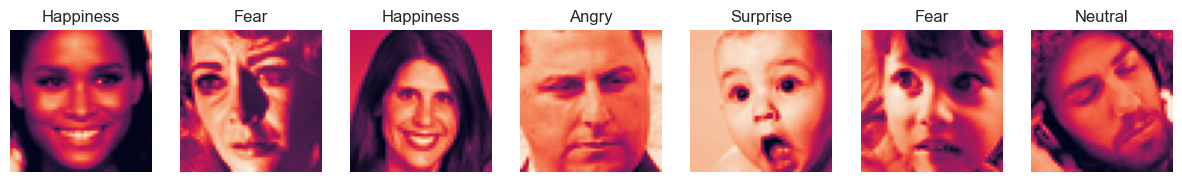

In [4]:
plt.figure(figsize=(15, 23))
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
i = 1
for i in range(7):
    img = np.squeeze(X_train[i])
    plt.subplot(1, 7, i + 1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [5]:
"""
Data augmentation using ImageDataGenerator - We can do data augmentation to have more data to train and validate
our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model
become more generalize and robust.
"""

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             zoom_range=0.2)
valgen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            zoom_range=0.2)

datagen.fit(X_train)
valgen.fit(X_val)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [6]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = cnn_model()

model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

Epoch 1/5



455/455 [==============================] - ETA: 0s - loss: 6.8650 - accuracy: 0.2138
Epoch 1: val_accuracy improved from -inf to 0.25077, saving model to best_model.h5
455/455 [==============================] - 392s 843ms/step - loss: 6.8650 - accuracy: 0.2138 - val_loss: 2.7093 - val_accuracy: 0.2508
Epoch 2/5
455/455 [==============================] - ETA: 0s - loss: 2.5600 - accuracy: 0.2936
Epoch 2: val_accuracy improved from 0.25077 to 0.27276, saving model to best_model.h5
455/455 [==============================] - 379s 833ms/step - loss: 2.5600 - accuracy: 0.2936 - val_loss: 2.7727 - val_accuracy: 0.2728
Epoch 3/5
455/455 [==============================] - ETA: 0s - loss: 2.5502 - accuracy: 0.3867
Epoch 3: val_accuracy improved from 0.27276 to 0.40588, saving model to best_model.h5
455/455 [==============================] - 374s 822ms/step - loss: 2.5502 - accuracy: 0.3867 - val_loss: 2.5826 - val_accuracy: 0.4059
Epoch 4/5
455/455 [==============================] - ETA: 0s - lo

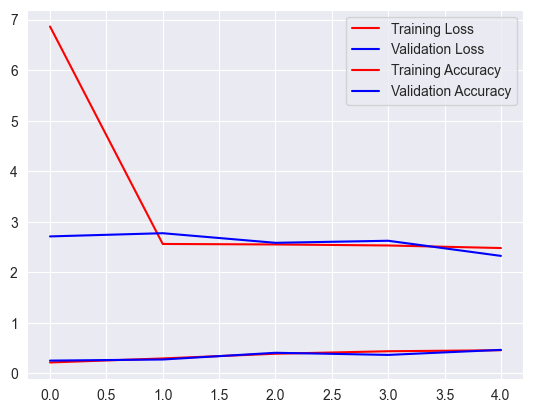

In [7]:
# Early stopping - Adding checkpointer to implement Early Stopping to prevent overfitting.
checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1,
                              restore_best_weights=True, mode="max", patience=5),
                ModelCheckpoint('best_model.h5', monitor="val_accuracy", verbose=1,
                                save_best_only=True, mode="max")]

history = model.fit(train_generator,
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

# Visualizing results
plt.plot(history.history["loss"], 'r', label="Training Loss")
plt.plot(history.history["val_loss"], 'b', label="Validation Loss")
plt.legend()

plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")
plt.legend()

loss = model.evaluate(X_test, y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 16s 138ms/step
              precision    recall  f1-score   support

           0      0.464     0.275     0.346       541
           1      0.000     0.000     0.000        53
           2      0.283     0.099     0.147       494
           3      0.626     0.864     0.726       888
           4      0.338     0.446     0.385       590
           5      0.887     0.334     0.485       422
           6      0.374     0.581     0.455       601

    accuracy                          0.479      3589
   macro avg      0.425     0.371     0.363      3589
weighted avg      0.486     0.479     0.448      3589



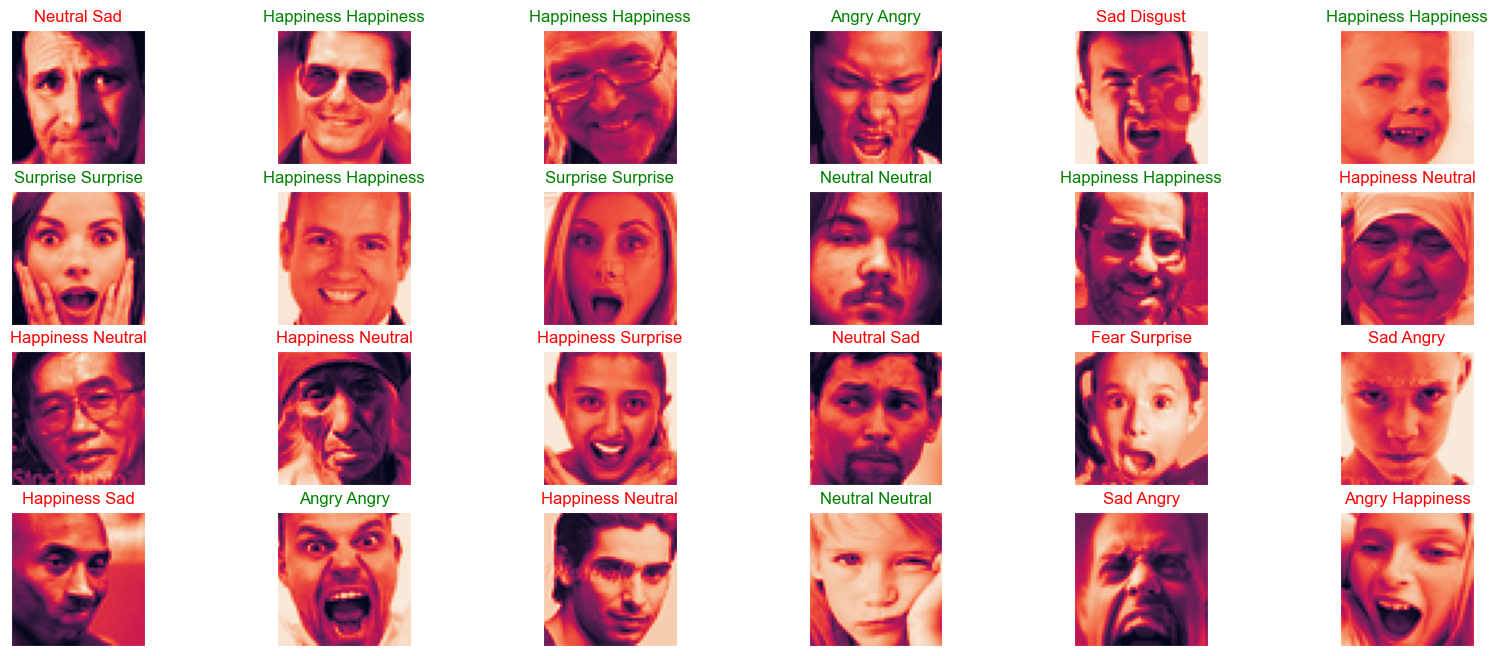

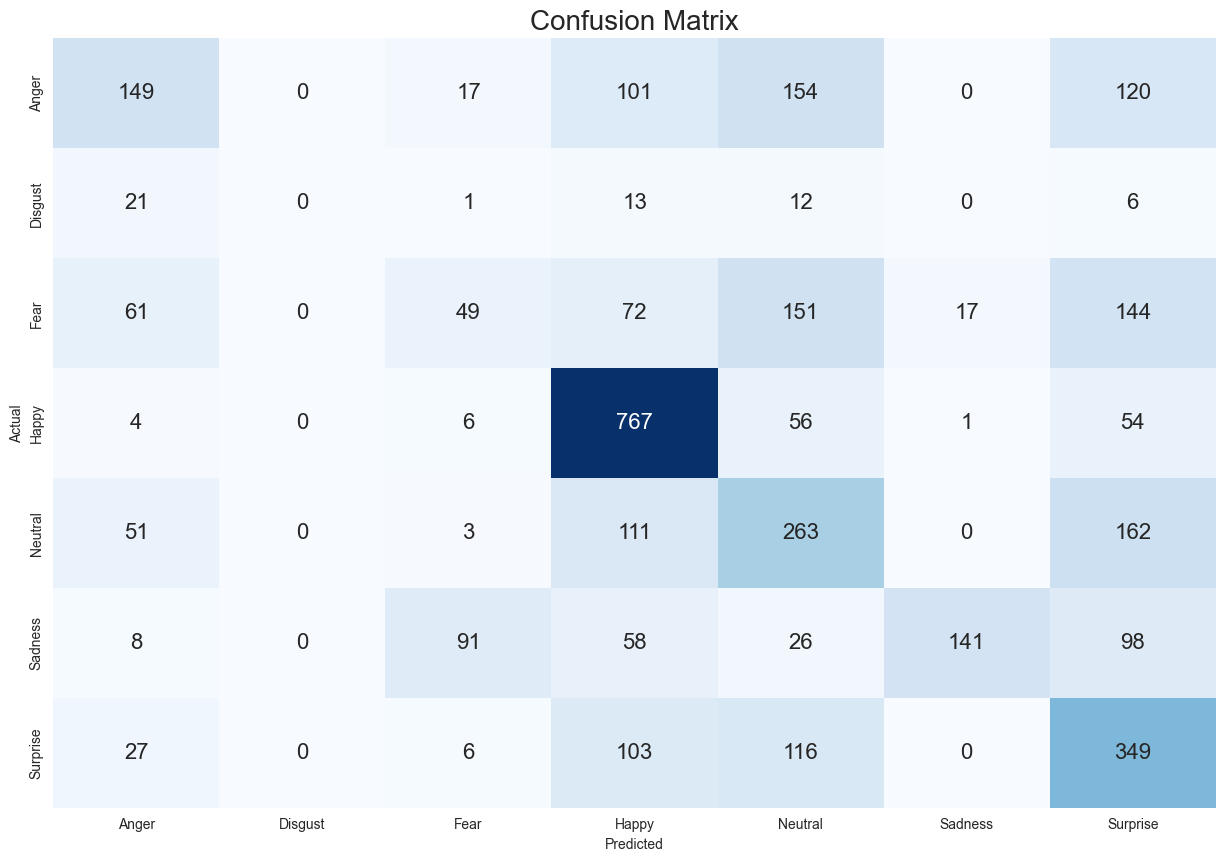

In [8]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]

    ax.set_title(f"{predict_index} {true_index}",
                 color=("green" if predict_index == true_index else "red"))

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=class_labels, index=class_labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=3))

In [ ]:
"""
------------- Fine Tuning -------------
"""
# The model trained with SGD did not give better results than Adam optimizer.
# So, Let's change the epoch number as 50 for the cnn_model.
# Needs a lot time.

model = cnn_model()
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1,
                              restore_best_weights=True, mode="max", patience=10),
                ModelCheckpoint('best_model.h5', monitor="val_accuracy", verbose=1,
                                save_best_only=True, mode="max")]

history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

loss = model.evaluate(X_test, y_test)
print("Test Acc: " + str(loss[1]))

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=class_labels, index=class_labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(20, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=3))

# The model trained with 50 epochs has better results than the model trained with 30 epochs.